## Assignment 9 Submission

In [2]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns
from scipy import stats

### Q1

2. Two pass approach from the pyMC suggestions

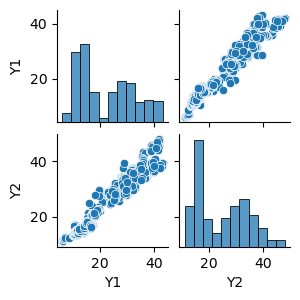

In [14]:
# Use the same data for hw8 q2
df = pd.read_csv("./../ENB2012_data.csv")
a = df["Y1"]
b = df["Y2"]
sns.pairplot(df[["Y1", "Y2"]], height=1.5)

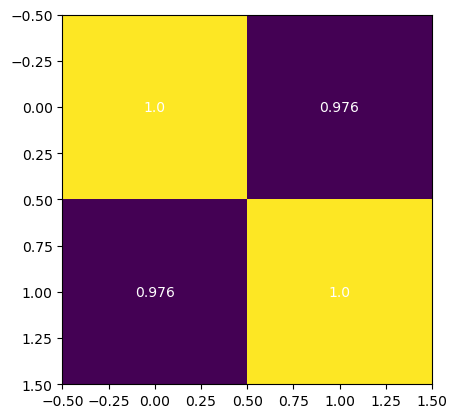

In [15]:
# The observed data correlation matrix
a_corr = np.corrcoef(a.to_numpy(), b.to_numpy())
plt.imshow(a_corr)
for k in range(2):
    for j in range(2):
        plt.text(j,k,s=str(round(a_corr[j,k],3)), 
                    color='w', va='center', ha='center')
plt.show()

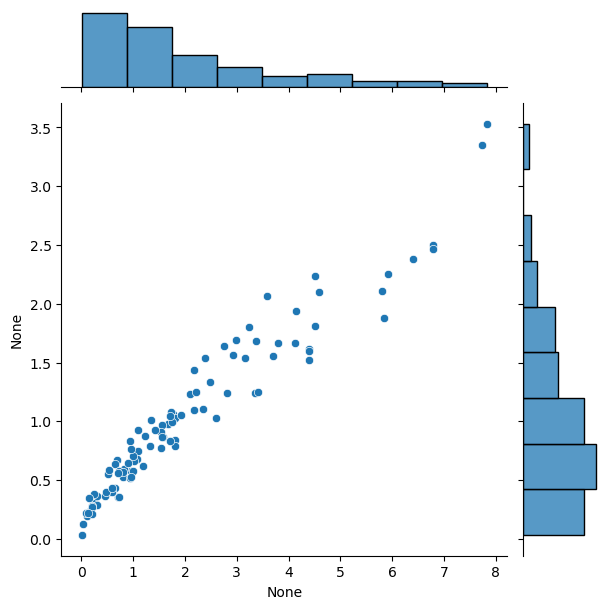

In [23]:
y = stats.multivariate_normal(mean=np.zeros(2), cov=a_corr).rvs(size=100)
a = stats.chi2(df=2).ppf(stats.norm(loc=0, scale=1).cdf(y[:, 0]))
b = stats.gamma(a=2, scale=0.5).ppf(stats.norm(loc=0, scale=1).cdf(y[:, 1]))
sns.jointplot(x=a, y=b)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_nu, b_a, b_b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


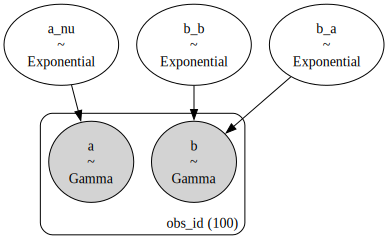

In [24]:
coords = {"obs_id": np.arange(len(a))}
with pm.Model(coords=coords) as marginal_model:
    # marginal estimation
    a_nu = pm.Exponential("a_nu", lam=0.5)
    pm.ChiSquared("a", nu=a_nu, observed=a, dims="obs_id")

    b_a = pm.Exponential("b_a", lam=0.5)
    b_b = pm.Exponential("b_b", lam=0.5)
    pm.Gamma("b", alpha=b_a, beta=b_b, observed=b, dims="obs_id")

    marginal_idata = pm.sample()

pm.model_graph.model_to_graphviz(marginal_model)

In [25]:
# point estimates
a_nu = marginal_idata.posterior["a_nu"].mean().item()
b_a = marginal_idata.posterior["b_a"].mean().item()
b_b = marginal_idata.posterior["b_b"].mean().item()
# transformations from observation space -> uniform space
__a = pt.exp(pm.logcdf(pm.ChiSquared.dist(nu=a_nu), a))
__b = pt.exp(pm.logcdf(pm.Gamma.dist(alpha=b_a, beta=b_b), b))
# uniform space -> multivariate normal space
_a = pm.math.probit(__a)
_b = pm.math.probit(__b)
# join into an Nx2 matrix
data = pt.math.stack([_a, _b], axis=1).eval()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 36 seconds.


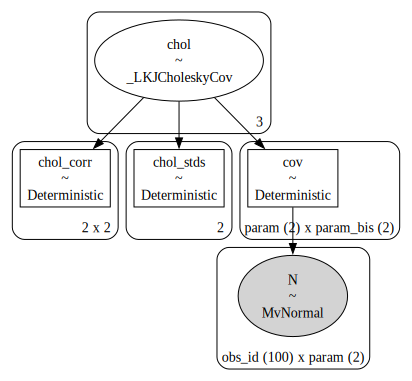

In [26]:
coords.update({"param": ["a", "b"], "param_bis": ["a", "b"]})
with pm.Model(coords=coords) as copula_model:
    # Prior on covariance of the multivariate normal
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=2,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("param", "param_bis"))

    # Likelihood function
    pm.MvNormal("N", mu=0.0, cov=cov, observed=data, dims=("obs_id", "param"))
    copula_idata = pm.sample(tune=2000)

pm.model_graph.model_to_graphviz(copula_model)

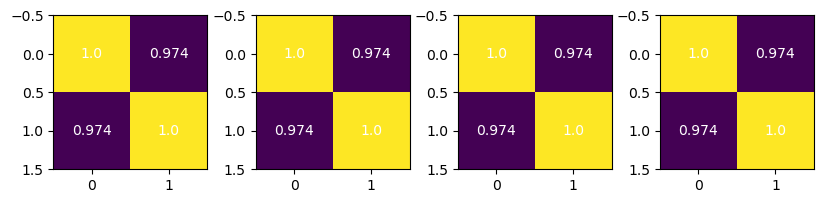

In [27]:
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(copula_idata.posterior['chol_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(2):
        for j in range(2):
            ax[i].text(j,k,s=str(round(c[j,k],3)), 
                       color='w', va='center', ha='center')

3. Copula is a multivariate c.d.f. function such that marginalizing each variable will give the standard uniform distribution. In other words, a copula $C(u_1,\ldots,u_p) = \Pr (U_1 \leq u_1,\ldots, U_p \leq u_p)$ for $U_i \sim U(0,1)$ for any $i$. For any random variable, we can construct $(U_1 \leq u_1,\ldots, U_p \leq u_p)$ by taking the cdf of itself, we will result into standard uniform distribution. $(U_1,\ldots, U_p) = (F_1(X_1),\ldots,F_p(X_p))$ for any existing cdf random variable $(X_1,\ldots,X_p)$.

Copula is useful when we try to model the complex correlation structures between multiple variables, by decomposing the joint pdf into marginalized pdf, and a copula. Which allows us to sample from the highly correlated multivariate samples. 

From the PyMC code, the copula is estimated by the two-pass method:
- First pass: sample from multivariate normal distribution with certain correlation $\rightarrow$ transform to standard uniform marginals $\rightarrow$ turn generate the observation space by taking the inverse cdf. This is called the data generating process.
- Second pass: get the estimate parameters of marginal distributions $\rightarrow$ standard uniform space $\rightarrow$ multivariate normal distribution $\rightarrow$ make an inference on the covariance parameters. This is called copula inference process. 

The example code in the question does not need the marginal parameter estimations. The code does the copula inference in one sampling process. First it samples from multivariate normal, and directly transform into the observation space (as we can see the code samples `p0`, `y0` and `p1`, `y1`), then samples from the observation space and directly converting the samples back to multivariate normal distribution (`pm.Deterministic`) without doing any marginals parameter estimations, unlinke PyMC.

The example code is theoretically a better choice because the two-pass approach in PyMC uses posterior mean estimation from the first pass, then propagate the parameters into the second pass. If the first pass estimates are poor estimates, then the second pass, and the copula may introduce huge inaccuracies. Therefore, removing this step and sample everything simultaneously might produce a better outcome.

4. Copula can make the multivariate GLM regression very flexible because we arbitrary create any joint p.d.f. of the response variable. Suppose $\mathbf{y}_{n\times m}$ is the multivariate response, and let $\mathbf{y}_{1:n,i}$ be the marginal output (the $i$-th column of the response). There is a high chance that $\mathbf{y}_{1:n,1},\ldots,\mathbf{y}_{1:n,m}$ will have different marginal distributions, thus different link function. Copula allows us to decompose those response variable using different link function, and perform univariate regression independently, and then combine back with the correlation structure captured by copula. 

Also, the one-pass approach will fully capture the variability of the parameter uncertainity because the two-pass approach only use posterior mean to estimate the parameter of the data, which is only a point estimate, where the one-pass approach uses every value in the chain to reproduce the multivariate normal samples.

### Q2

In [134]:
# Use the same data again
df = pd.read_csv("./../ENB2012_data.csv")
df = df.sample(n=100)
X = df.drop(["Y1", "Y2"], axis = 1)
Y = df[["Y1", "Y2"]]
Y -= Y.mean(); Y /= Y.std()
X -= X.mean(); X /= X.std()
X = X.to_numpy()
Y = Y.to_numpy()
n, m, p = len(df), len(Y[0]), len(X[0])

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, beta0, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 215 seconds.


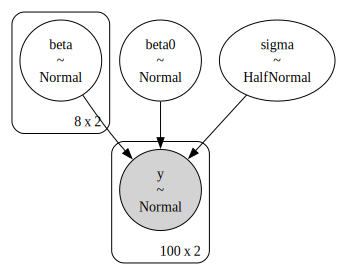

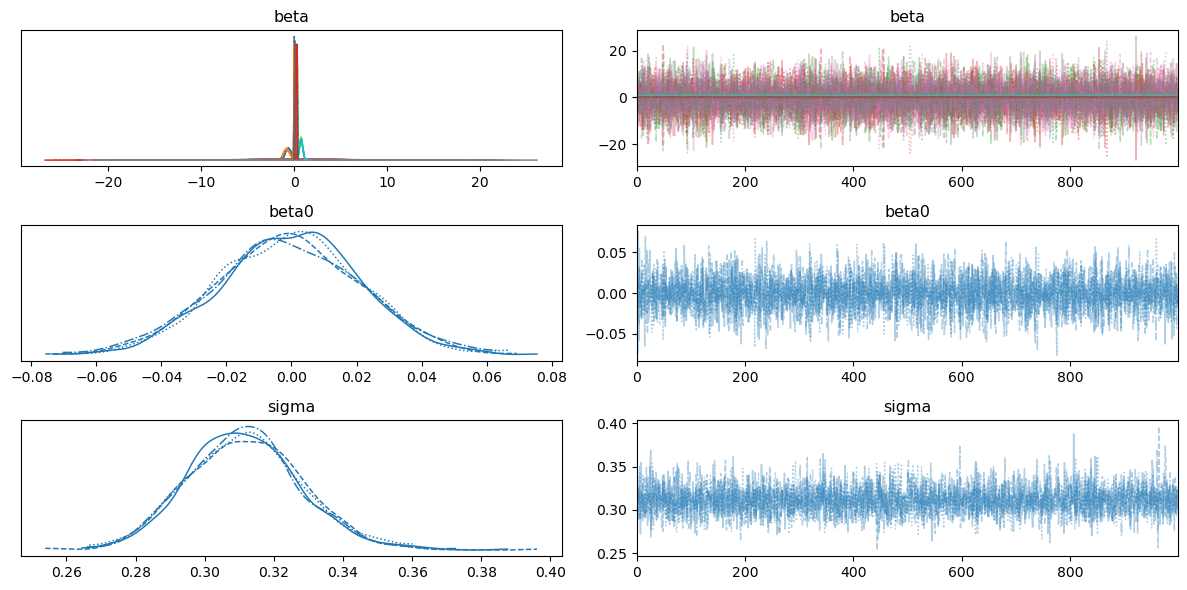

In [135]:
# L2 regularization
with pm.Model() as diffuse:
    beta = pm.Normal("beta", mu=0, sigma=10, shape=(p, m))
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=100)
    y = pm.Normal("y", mu=beta0+(X @ beta), sigma=sigma, observed=Y)
    idata2 = pm.sample(step=pm.NUTS(max_treedepth=20))
az.plot_trace(idata2)
plt.tight_layout()
pm.model_to_graphviz(diffuse)

Observing only `beta` variable of the trace plot, we can see that the some values of $\beta_i$ are clustered at $\beta_i = 0$ on the left, and some place slightly off the 0 value, which may indicates that we should select that variable. However, if we observe the sample drawn from the right, we can see that all of the $\beta$'s are scattered between $(-20,20)$ range, which indicates that $L_2$-regularization does not inherently perform variable selection.

Now we move on the spike and slab multivariate regression.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pr, slab, beta0]
>BinaryGibbsMetropolis: [spike]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
c:\Users\lotto\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\lotto\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite 

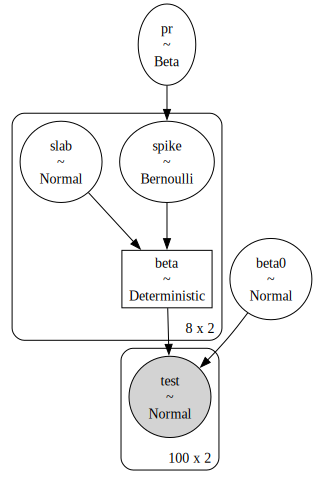

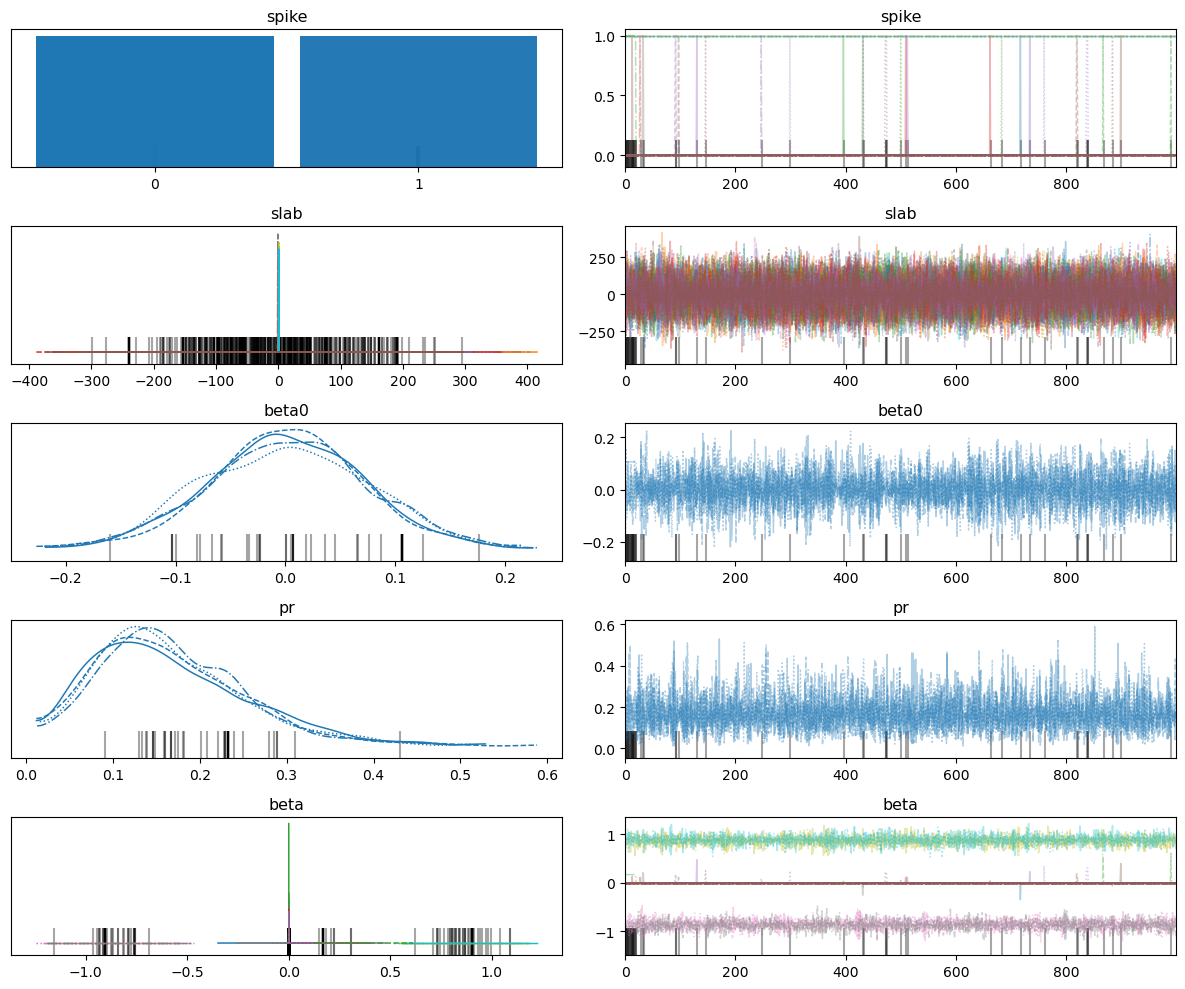

In [136]:
# Using spike and slab
with pm.Model() as spike_and_slab:
    pr = pm.Beta("pr", alpha=1, beta=1)
    spike = pm.Bernoulli("spike", p=pr, shape=(p, m))
    slab = pm.Normal("slab", mu=0, sigma=100, shape=(p, m))
    beta = pm.Deterministic("beta", spike*slab)
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    test = pm.Normal("test", mu=beta0+ (X @ beta), sigma=1, observed=Y)
    idata = pm.sample(step=pm.NUTS(max_treedepth=20))
az.plot_trace(idata)
plt.tight_layout()
pm.model_to_graphviz(spike_and_slab)

Likewise, focusing only `beta` variable, we can see that there are sharp spikes that occur at $\beta_i=0$ and some "selected" values by spike and slab will cluster at $(-1,-0.5)$ and $(0.5,1)$. From the trace plot on the right, there is clear distinction between the $\beta$'s that are selected, and $\beta$'s that are not. Where the selected $\beta$'s will be placed outside of the zero value, which indicates that spike and slab is performing variable selection, unlike $L_2$-regularization.

We also downsample the data from $n=768$ to $n=100$ due to heavy computation. Increasing $n,m,p$ will greatly impact the speed of computation. For example, increasing $n$ from 100 to 768 (original dataset) could change the computation time from 1 minute 30 seconds to over 30 minutes. This happens because of the time and resource demands of the matrix operation (increasing in polynomial time).

### Q3

This question, we will perform only using horseshoe prior on multivriate regression. The spike and slab method is already done in Q2, which will be used in Q3 to compare the performance with horseshoe prior.

In [137]:
# Again
df = pd.read_csv("./../ENB2012_data.csv")
df = df.sample(n=100)
X = df.drop(["Y1", "Y2"], axis = 1)
Y = df[["Y1", "Y2"]]
Y -= Y.mean(); Y /= Y.std()
X -= X.mean(); X /= X.std()
X = X.to_numpy()
Y = Y.to_numpy()
n, m, p = len(df), len(Y[0]), len(X[0])
n, m, p

(100, 2, 8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c_sq, z, beta0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


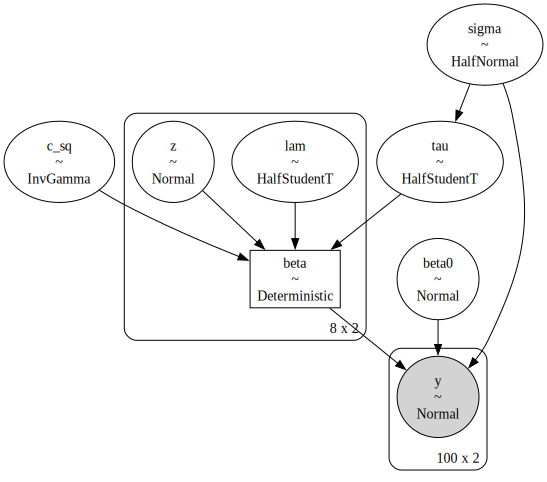

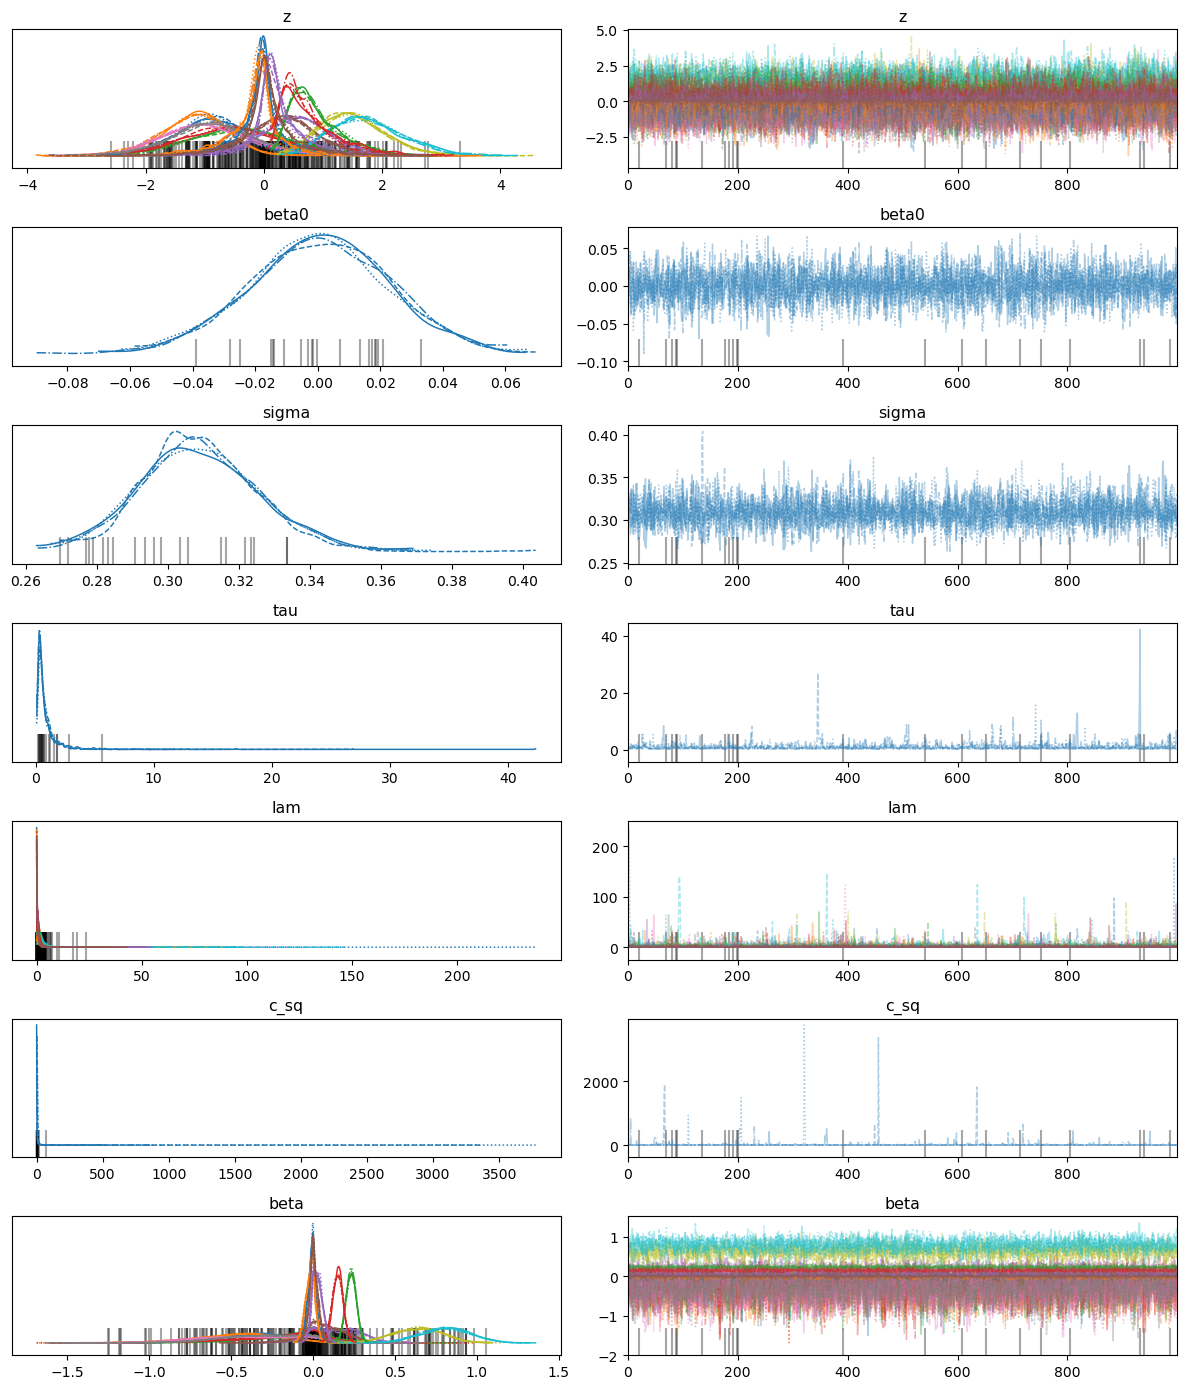

In [138]:
# According to the horseshoe prior from PyMC
p0 = p//2
with pm.Model() as horseshoe:
    sigma = pm.HalfNormal("sigma", sigma=10)
    tau = pm.HalfStudentT("tau", nu=2, sigma=p0 / (p-p0) * sigma / np.sqrt(n))
    lam = pm.HalfStudentT("lam", nu=2, shape=(p, m))
    c_sq = pm.InverseGamma("c_sq", alpha=1, beta=0.1)
    z = pm.Normal("z", mu=0, sigma=1, shape=(p, m))
    beta = pm.Deterministic("beta", z*tau*lam*np.sqrt(c_sq / (c_sq + tau**2 + lam**2)))
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    y = pm.Normal("y", mu=beta0+(X @ beta), sigma=sigma, observed=Y)
    idata = pm.sample()
az.plot_trace(idata)
plt.tight_layout()
pm.model_to_graphviz(horseshoe)

The horseshoe prior method is able to capture the variability of the $\beta$'s in the regression better than the spike and slab method. The insignificant $\beta$ will stay around zero value, like in spike and slab, and have very sharp distribution peaked at 0. The spike and slab method, we can see one single line coming out at 0 (because it is not selected value), while horseshoe prior will give every $\beta$ certain distribution and variability from the data.